In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg

# Read in the data and fix dtypes

In [2]:
df = pd.read_csv('rates.csv')

# change '.' entries to nan so they are easier to deal with in functions
df.DGS30[df.DGS30=='.']=np.nan
df.DGS30 = df.DGS30.astype('float64')

/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_6578/125850606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DGS30[df.DGS30=='.']=np.nan


# 1. Find the mean and the variance of each time series for the entire time period. Do the same for the common time period. 

In [3]:
print('Means for entire time period: \n \n', df[['DGS10','MORTGAGE30US', 'DGS30', 'AAA']].mean(), '\n \n', 'Variances for entire time period: \n \n', df[['DGS10','MORTGAGE30US', 'DGS30', 'AAA']].var())



Means for entire time period: 
 
 DGS10           5.974872
MORTGAGE30US    7.738512
DGS30           6.238880
AAA             7.135075
dtype: float64 
 
 Variances for entire time period: 
 
 DGS10           10.568399
MORTGAGE30US    11.115838
DGS30            9.216175
AAA              8.367469
dtype: float64


In [4]:
print('Means for common time period: \n \n', df[['DGS10','MORTGAGE30US', 'DGS30', 'AAA']].dropna().mean(), '\n \n', 'Variances for common time period: \n \n', df[['DGS10','MORTGAGE30US', 'DGS30', 'AAA']].dropna().var())




Means for common time period: 
 
 DGS10           5.858648
MORTGAGE30US    7.652488
DGS30           6.238880
AAA             7.037780
dtype: float64 
 
 Variances for common time period: 
 
 DGS10           11.059629
MORTGAGE30US    11.740897
DGS30            9.216175
AAA              8.774280
dtype: float64


# 2. Regress 10-year interest rates upon itself with 1-month lag (AR of order 1). Show output. Analyze residuals for normality. 

In [5]:
mod = AutoReg(df.DGS10, lags=1)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  DGS10   No. Observations:                  601
Model:                     AutoReg(1)   Log Likelihood                -122.733
Method:               Conditional MLE   S.D. of innovations              0.297
Date:                Tue, 06 Feb 2024   AIC                            251.465
Time:                        20:47:38   BIC                            264.656
Sample:                             1   HQIC                           256.600
                                  601                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.025      0.743      0.457      -0.031       0.069
DGS10.L1       0.9960      0.004    267.071      0.000       0.989       1.003
                                    Roots           

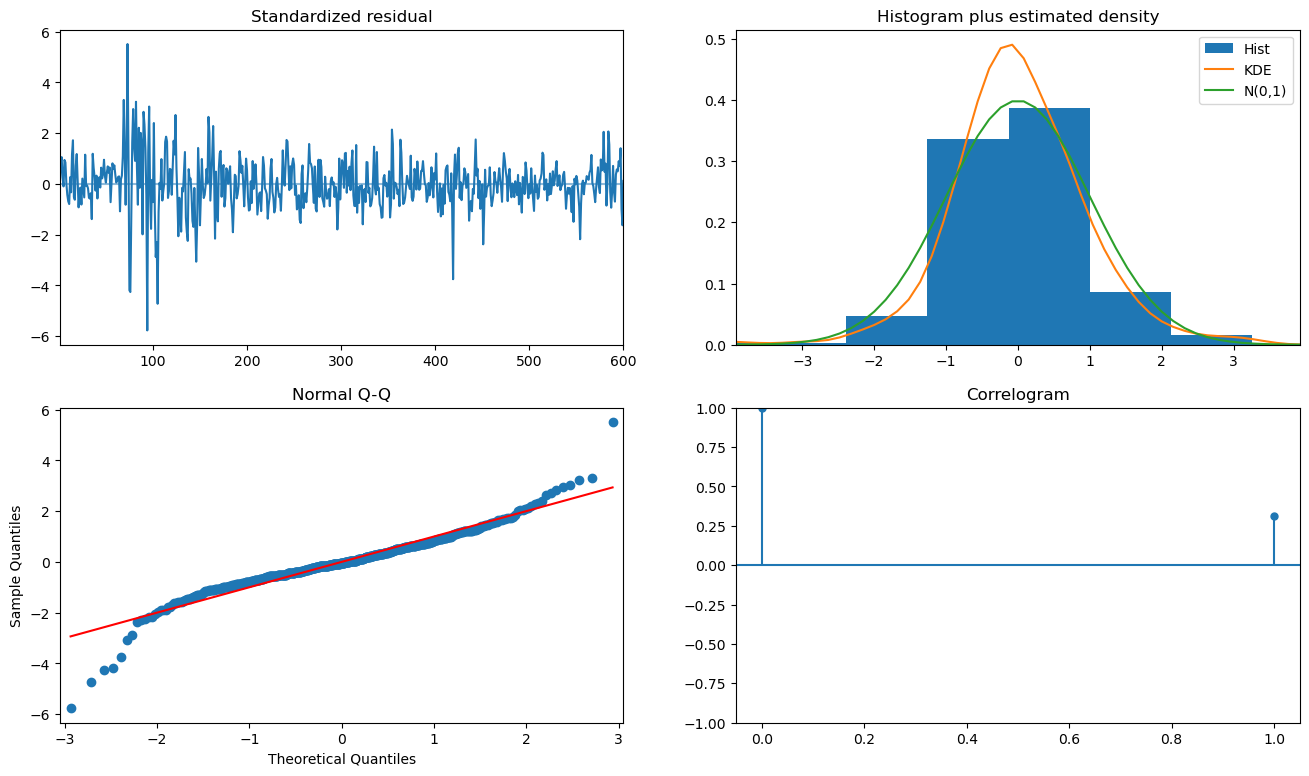

In [6]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=1, fig=fig)

In [7]:
scipy.stats.shapiro(res.resid)

ShapiroResult(statistic=0.9389000535011292, pvalue=5.595498379012487e-15)

# 3. Regress 30-year mortgage rates upon three other rates. Show output. Analyze residuals for normality. Are all factors significant?

In [8]:
mod = smf.ols(formula='MORTGAGE30US ~ DGS10 + DGS30 + AAA', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.207e+04
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:47:39   Log-Likelihood:                -313.26
No. Observations:                 563   AIC:                             634.5
Df Residuals:                     559   BIC:                             651.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0812      0.097     11.140      0.0

ShapiroResult(statistic=0.8606145977973938, pvalue=6.044019005410937e-22)


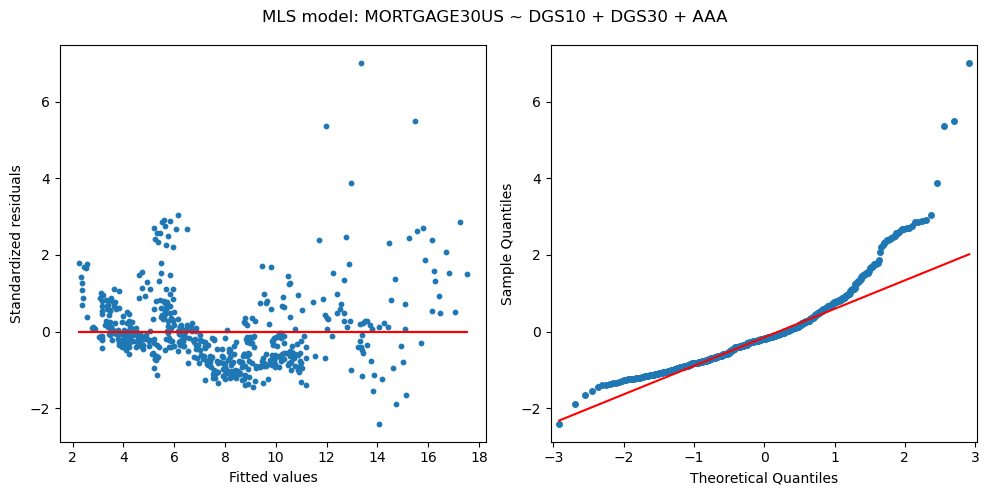

In [9]:
print(scipy.stats.shapiro(res.resid))
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(10,5), layout='tight')

plt.suptitle('MLS model: MORTGAGE30US ~ DGS10 + DGS30 + AAA')

slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].scatter(res.fittedvalues, res.resid_pearson, s=10, rasterized=True)
ax[0].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[0].set_xlabel ('Fitted values')
ax[0].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', markersize=4, ax=ax[1], rasterized=True)
plt.show()

